# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
#Import libraries
from nltk.tokenize import word_tokenize
from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.exceptions import UndefinedMetricWarning
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sqlalchemy import create_engine
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from Tokenize import tokenize
import numpy as np
import pandas as pd
import pickle
import nltk
import re
def warn(*args, **kwargs):
    pass
import warnings
warnings.filterwarnings('always')
warnings.warn = warn

warnings.simplefilter("ignore", ResourceWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning) 

nltk.download(['punkt', 'wordnet', 'stopwords' ])


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
#Read the data from DisasterResponse table created in the ETL pipeline
engine = create_engine('sqlite:///InsertDatabaseName.db')
df = pd.read_sql_table( 'DisasterResponse' , engine)
#Define feature
X = df['message']
#Define target classes
Y = df[df.columns[:-5]]
category_names = list(Y.columns)

In [3]:
X.shape

(26216,)

In [4]:
Y.shape

(26216, 35)

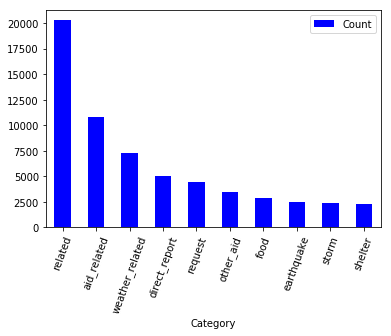

In [5]:
#Create a chart that displays top 10 categories
df_categories = df[['related', 'request', 'offer', 'aid_related', 'medical_help',
       'medical_products', 'search_and_rescue', 'security', 'military',
       'child_alone', 'water', 'food', 'shelter', 'clothing', 'money',
       'missing_people', 'refugees', 'death', 'other_aid',
       'infrastructure_related', 'transport', 'buildings', 'electricity',
       'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure',
       'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold',
       'other_weather', 'direct_report']]

#Create a dataframe that will sum for all categories and store top 10 in a new dataframe
df_top_10_catg = df_categories.sum().sort_values(ascending = False).head(10).to_frame() \
                                    .reset_index().rename(columns={'index' :'Category', 0:'Count'})

df_top_10_catg.sort_values(by = "Count" , ascending = False , inplace = True)

#Plot the dataset
plt.figure(figsize=(10,4))
df_top_10_catg.plot(kind='bar',y='Count',x='Category',color='b')
plt.xticks(rotation=70);


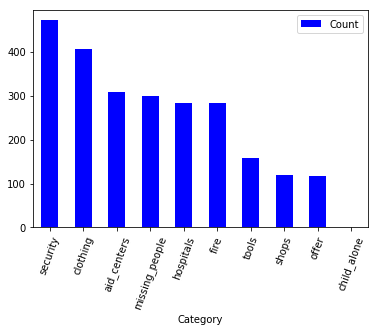

In [6]:
#Create a dataframe that will sum for all categories and store bottom 10 in a new dataframe
df_tail_10_catg = df_categories.sum().sort_values(ascending = False).tail(10).to_frame() \
                                    .reset_index().rename(columns={'index' :'Category', 0:'Count'})

df_tail_10_catg.sort_values(by = "Count" , ascending = False , inplace = True)

#Plot the dataset
plt.figure(figsize=(10,4))
df_tail_10_catg.plot(kind='bar',y='Count',x='Category',color='b')
plt.xticks(rotation=70);

### 2. Write a tokenization function to process your text data

In [ ]:
def tokenize(text):
    '''Input: text data
       Output: text data cleaned
    '''
    #Convert to lower cases
    text = text.lower()
    #Remove punctuation 
    text = re.sub(r'[^\w\s]', '', text)

    # Loop all words and replace with empty space to remove numbers 
    for i in text:
        if i.isdigit():
            text = text.replace(i, '')

    #Tokenzie      
    words = word_tokenize(text)
 
    #Remove stopwords

    words = [w for w in words if w not in stopwords.words("english")]

    #Reduce words to their root form , overwrite the default parameter 'words' to 'verb'
    lemmed = [WordNetLemmatizer().lemmatize(w , pos = 'v') for w in words]

    return lemmed

- Test above function with data from training set

In [7]:
print(f'Original message:\n{X[12]}' )

Original message:
I am in Thomassin number 32, in the area named Pyron. I would like to have some water. Thank God we are fine, but we desperately need water. Thanks


In [8]:
print(f'Transformed message:\n{tokenize(X[12])}' )

Transformed message:
['thomassin', 'number', 'area', 'name', 'pyron', 'would', 'like', 'water', 'thank', 'god', 'fine', 'desperately', 'need', 'water', 'thank']


In [9]:
print(f'Original message:\n{X[33]}' )

Original message:
People have been sleeping outdoors in a field near Lilavois since 12 Jan. No coords on Lilavois but apparently it is near PaP


In [10]:
print(f'Transformed message:\n{tokenize(X[33])}' )

Transformed message:
['people', 'sleep', 'outdoors', 'field', 'near', 'lilavois', 'since', 'jan', 'coords', 'lilavois', 'apparently', 'near', 'pap']


### 3. Build a machine learning pipeline

This machine learning piple takes message column as input and output classification results on the other 36 categories in the dataset.

In [11]:
#For creating below pipeline I am using a list of (key, value) to simplify the code for this ML task
#Pipeline below contains an estimator, a transformer and a predictor
pipeline_rf = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(RandomForestClassifier(random_state = 1))) 
])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, Y , random_state = 1)
pipeline_rf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...1,
            oob_score=False, random_state=1, verbose=0, warm_start=False),
           n_jobs=1))])

### 5. Test  the model 
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [93]:
pipeline_rf.fit(X_train, y_train)
y_pred = pipeline_rf.predict(X_test)
 

In [94]:
# predict on test data
def model_performance(X_test , y_test , pipeline , category_names ):
    '''Inputs: X_test and y_test this function takes as parameters X_test , y_test and corresonding model's pipeline and name
       Outputs: Function prints: 1. Precision, Recall and f1-score for each of the predited feature 
                                 2. Overall model's accuracy
    '''
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    for i , col_name in zip(range(len(category_names)) , category_names):
        print(f"{i} Metrics for {col_name} :" )
        print(classification_report(y_test[col_name], y_pred[: , i]))

    accuracy = (y_pred == y_test.values).mean()

    print(f"Model accuracy is {accuracy:.2f}" )

- Print results for RandomForest classifier

In [100]:
model_performance(X_test , y_test , pipeline_rf , category_names)

0 Metrics for related :
             precision    recall  f1-score   support

          0       0.63      0.47      0.54      1550
          1       0.84      0.91      0.88      4951
          2       0.71      0.23      0.34        53

avg / total       0.79      0.80      0.79      6554

1 Metrics for request :
             precision    recall  f1-score   support

          0       0.89      0.98      0.93      5415
          1       0.80      0.43      0.56      1139

avg / total       0.87      0.88      0.87      6554

2 Metrics for offer :
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      6528
          1       0.00      0.00      0.00        26

avg / total       0.99      1.00      0.99      6554

3 Metrics for aid_related :
             precision    recall  f1-score   support

          0       0.74      0.85      0.79      3815
          1       0.74      0.58      0.65      2739

avg / total       0.74      0.74      0.73 

### 6 . Build pipelines for  k-Nearest Neighbors and Naive Bayes and print their results

- K-Nearest Neighbor 

In [102]:
#Build a pipeline for KNN
pipeline_KNN = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(KNeighborsClassifier())) ])

#Train the data using above created pipeline
pipeline_KNN.fit(X_train, y_train)

#Call model performance function to print results
model_performance(X_test , y_test , pipeline_KNN , category_names)

0 Metrics for related :
             precision    recall  f1-score   support

          0       0.52      0.47      0.49      1550
          1       0.83      0.86      0.85      4951
          2       0.62      0.15      0.24        53

avg / total       0.76      0.76      0.76      6554

1 Metrics for request :
             precision    recall  f1-score   support

          0       0.86      0.98      0.92      5415
          1       0.77      0.27      0.39      1139

avg / total       0.85      0.86      0.83      6554

2 Metrics for offer :
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      6528
          1       0.00      0.00      0.00        26

avg / total       0.99      1.00      0.99      6554

3 Metrics for aid_related :
             precision    recall  f1-score   support

          0       0.63      0.94      0.76      3815
          1       0.74      0.24      0.36      2739

avg / total       0.68      0.65      0.59 

- Naive Bayes

In [107]:
#Build a pipeline for Naive Bayes
pipeline_NB = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(MultinomialNB()) ) ])

#Train the data using above created pipeline
pipeline_NB.fit(X_train, y_train)

#Call model performance function to print results
model_performance(X_test , y_test , pipeline_NB , category_names)

0 Metrics for related :
             precision    recall  f1-score   support

          0       0.84      0.08      0.14      1550
          1       0.77      1.00      0.87      4951
          2       0.00      0.00      0.00        53

avg / total       0.78      0.77      0.69      6554

1 Metrics for request :
             precision    recall  f1-score   support

          0       0.86      0.99      0.92      5415
          1       0.87      0.20      0.33      1139

avg / total       0.86      0.86      0.82      6554

2 Metrics for offer :
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      6528
          1       0.00      0.00      0.00        26

avg / total       0.99      1.00      0.99      6554

3 Metrics for aid_related :
             precision    recall  f1-score   support

          0       0.76      0.84      0.80      3815
          1       0.74      0.62      0.67      2739

avg / total       0.75      0.75      0.75 

### 7. Improve the chosen models

For finding best parameters I will use grid search cross validation

#### Grid search for Random Forest

In [108]:
#Parameters that will be used for hyperparameter optimization are number of estimators and tfidf for text document
parameters = {
        'tfidf__use_idf': (True, False),
        'clf__estimator__n_estimators': [5,10] # this tends to perform better as the number of trees increases but it requires a lot of time 
         }

cv_rf = GridSearchCV(pipeline_rf, param_grid=parameters) 


#### Grid search for Naive Bayes

In [109]:
#For Naive Bayes will use only tfidf
parameters = {
        'tfidf__use_idf': (True, False) }
nb = GridSearchCV(pipeline_NB, param_grid=parameters) 


### 8. Test the tuned models

- Print results for Random Forest

In [111]:
model_performance(X_test , y_test , cv_rf , category_names)

0 Metrics for related :
             precision    recall  f1-score   support

          0       0.63      0.47      0.54      1550
          1       0.84      0.91      0.88      4951
          2       0.71      0.23      0.34        53

avg / total       0.79      0.80      0.79      6554

1 Metrics for request :
             precision    recall  f1-score   support

          0       0.89      0.98      0.93      5415
          1       0.80      0.43      0.56      1139

avg / total       0.87      0.88      0.87      6554

2 Metrics for offer :
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      6528
          1       0.00      0.00      0.00        26

avg / total       0.99      1.00      0.99      6554

3 Metrics for aid_related :
             precision    recall  f1-score   support

          0       0.74      0.85      0.79      3815
          1       0.74      0.58      0.65      2739

avg / total       0.74      0.74      0.73 

- Print results for Naive Bayes

In [112]:
model_performance(X_test , y_test , nb , category_names)

0 Metrics for related :
             precision    recall  f1-score   support

          0       0.84      0.06      0.12      1550
          1       0.77      1.00      0.87      4951
          2       0.00      0.00      0.00        53

avg / total       0.78      0.77      0.68      6554

1 Metrics for request :
             precision    recall  f1-score   support

          0       0.85      1.00      0.92      5415
          1       0.89      0.16      0.27      1139

avg / total       0.86      0.85      0.81      6554

2 Metrics for offer :
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      6528
          1       0.00      0.00      0.00        26

avg / total       0.99      1.00      0.99      6554

3 Metrics for aid_related :
             precision    recall  f1-score   support

          0       0.76      0.85      0.80      3815
          1       0.75      0.62      0.68      2739

avg / total       0.76      0.76      0.75 

### 9. Export model as a pickle file

In [114]:
rf_model = 'classifier.pkl'
with open (rf_model, 'wb') as f:
    pickle.dump(cv_rf, f)